node degree clustering
0 4 0.3333333333333333
1 5 0.3
2 4 0.16666666666666666
3 4 0.5
4 4 0.16666666666666666
5 2 0
6 2 0
7 5 0.3
8 5 0.2
9 5 0.3

the adjacency list
0 8 2 9 1
1 2 4 9 3
2 7 6
3 9 8 7
4 7 6 8
5 8 9
6
7 9 8
8
9


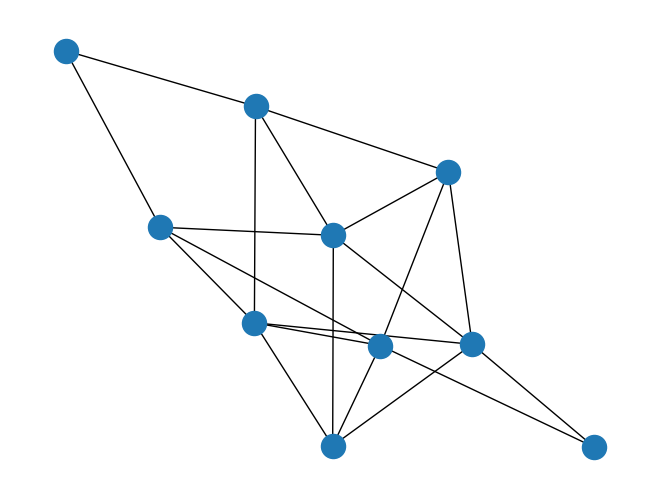

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

n = 10  # 50 nodes
m = 20  # 100 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

# some properties
print("node degree clustering")
for v in nx.nodes(G):
    print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

print()
print("the adjacency list")
for line in nx.generate_adjlist(G):
    print(line)

pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos)
plt.show()

## Testing Inner-GA

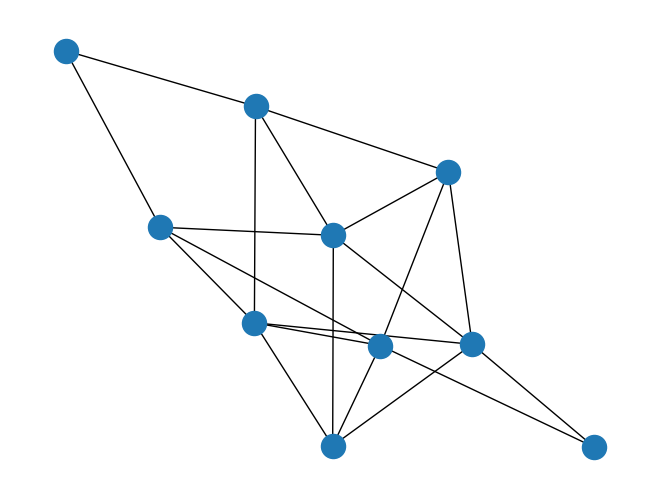

In [2]:
n = 10  # 50 nodes
m = 20  # 100 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)
pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos)
plt.show()

In [3]:
import numpy as np
from numpy.random import randint, uniform

links = [x for x in G.edges()]
capacity =  np.array([randint(100, 350) for _ in range(len(links))])
flow = np.array([uniform(1, x*0.95) for x in capacity])

In [4]:
def generate_population(size: int, capacity: list):
    population = []
    for _ in range(size):
        population.append([uniform(1, x*0.95) for x in capacity])
    return np.array(population)

In [5]:
# population = generate_population(20, capacity)

In [6]:
# population

In [7]:
from numpy.random import random, randint, choice
def scatter_crossover(parent1: np.array, parent2: np.array, alpha: int, indpb = 0.8):
    if random() > indpb:
        return False
        
    c1 = np.copy(parent1)
    c2 = np.copy(parent2)
    
    n_genes = len(parent1)
    scatter_point = np.random.choice(n_genes, size=int(alpha * n_genes), replace=False)
    
    for i in scatter_point:
        c1[i] = parent2[i]
        c2[i] = parent1[i]
    
    return c1, c2

In [8]:
# scatter_crossover(population[0], population[1], 0.5)

In [9]:
def fitness_inga(capacity: np.array, flow: np.array):
    
    if (flow > (capacity * 0.95)).any() or flow.sum() < (capacity.sum()*0.5):
        return 0
    
    sigma = flow.sum()
    temp = (flow/(capacity-flow)).sum()
    T = temp/sigma
    return 1/T

def gautil(flow: np.array, capacity: np.array):
    return flow/capacity

In [10]:
# fitness_inga(capacity, population[7])

In [11]:
# gautil(population[0], capacity)

In [12]:
def tournament_selection(size: int, pop: np.array, fitness: np.array, k=5):

    index = []
    population = list(pop)
    select = []
    for _ in range(size):
        selection_ix = randint(len(population))
        for ix in np.random.randint(0, len(population), k-1):
            if fitness[ix] > fitness[selection_ix]:
                selection_ix = ix
        select.append(population.pop(selection_ix))
        index.append(selection_ix)

    return np.array(select), np.array(index)

In [13]:
from deap.tools import mutGaussian

def innerga(size=10, generasi=100, capacity=None, alpha=0.5, pMu=0.2, pCr=0.8):
    pop = generate_population(size, capacity)
    average_fitness = []
    
    for gen in range(generasi):
        fitness = np.array([fitness_inga(capacity=capacity, flow=ind) for ind in pop])
        
        average_fitness.append([gen, np.mean(fitness)])
        
        selected, _ = tournament_selection(size=size,pop=pop, fitness=fitness)
        
        sh = selected[0].shape[0]
        offspring = np.empty((0, sh))
        
        for p1, p2 in zip(selected[::2], selected[1::2]):
            if cross := scatter_crossover(alpha=alpha, parent1=p1, parent2=p2, indpb=pCr):
                c1, c2 = cross
                offspring = np.append(offspring, c1.reshape(1, sh), axis=0)
                offspring = np.append(offspring, c2.reshape(1, sh), axis=0)
            else:
                offspring = np.append(offspring, p1.reshape(1, sh), axis=0)
                offspring = np.append(offspring, p2.reshape(1, sh), axis=0)
            
        for m in offspring:
            mut = mutGaussian(m, 0, 1, pMu)[0]
            offspring = np.append(offspring, mut.reshape(1, sh), axis=0)
        
        pop = offspring

    return pop, np.array([fitness_inga(capacity=capacity, flow=ind) for ind in pop]), np.array(average_fitness)
    

In [14]:
# a, b = innerga(size=300, generasi=500, capacity=capacity)

## Outer GA

In [15]:
from functools import partial

def filter_edge(capacity, g):
    graph = nx.to_networkx_graph(g).edges()
    def filter_func(pair, graph):
        ed = set(graph)
        k, _ = pair
        if k in ed:
            return True
        else:
            return False
    filter_f = partial(filter_func, graph=graph)
    return dict(filter(filter_f, capacity.items()))

def generate_graph(size=10, nodes=10, edges=20, capacity=None):
    
    if capacity is None:
        capacity = {}
        G = nx.complete_graph(nodes) 
        for edge in G.edges:
            capacity[edge] =  randint(60, 300)
    graph = []    
    while len(graph) < size:
        temp_g = nx.gnm_random_graph(n=nodes, m=edges)
        if nx.is_connected(temp_g):
            graph.append(nx.to_numpy_array(temp_g))
    graph = np.array(graph)
            
    graph_cap = np.array([list(filter_edge(capacity, G).values()) for G in graph])
    return graph, graph_cap, capacity

In [16]:
# g, gc, c = generate_graph()

In [17]:

from numpy.random import choice, randint, random

def clone_ind(size, pCl):
    idx = choice(a=size, size = int(np.ceil(pCl*size)), replace=False)
    return idx


In [18]:
# clone_ind(10, 0.2)

In [19]:
def mutate_outga(individual, global_cap, pMu=0.2):
    if random() > pMu:
        return False
    G = nx.to_networkx_graph(individual)
    edges = list(G.edges())
    n_nodes = G.number_of_nodes()
    edge = edges[choice(a=len(edges))]
    s, t = edge
    exclusion = [s, t]
    source = choice(exclusion)
    for s, t in edges:
        if s == source:
            exclusion.append(t)
        elif t == source:
            exclusion.append(s)
    
    i = choice(a=[i for i in range(n_nodes) if i not in exclusion ])
    ind = individual.copy()
    ind[s][t] = 0
    ind[t][s] = 0
    
    ind[source][i] = 1
    ind[i][source] = 1

    if not nx.is_connected(nx.to_networkx_graph(ind)):
        return False
    
    graph_cap = np.array([list(filter_edge(global_cap, ind).values())])
    
    return ind, graph_cap


In [20]:
# tas, tis = mutate_outga(g[2], c, 1)

In [21]:
# tas

In [22]:
def crossover_outga(parent1, parent2, global_cap, edge_size,pCr=0.8):
    def connectivity_fix(matrix):
        G = nx.to_networkx_graph(matrix)
        edges = np.array(G.edges())
        iterations = 0
        while iterations < 100:
            # print(iterations)
            adjMatrix = matrix.copy()
            edge = edges[choice(a=len(edges), size=nr_edge,replace=False)]
            for s, t in edge:
                adjMatrix[s][t] = 0
                adjMatrix[t][s] = 0
                
            if nx.is_connected(nx.to_networkx_graph(adjMatrix)):
                return True, adjMatrix
            else:
                iterations += 1
            
        return False
                
    if random() > pCr:
        return False
    p1, p2 = parent1.copy(), parent2.copy()
    chrom_len = len(p1)
    temp = (p1 + p2) / 2

    redundant = np.floor(temp)
    new_pair = np.ceil(temp - redundant)
    total_pair = redundant + new_pair

    redundant_sum = redundant.sum()/2
    np_sum = new_pair.sum()/2
    current_sum = redundant_sum + np_sum
    
    final_top = total_pair
    if current_sum > edge_size:
        nr_edge = int(current_sum - edge_size)
        if nr_edge == redundant_sum:
            if nx.is_connected(nx.to_networkx_graph(new_pair)):
                final_top = new_pair
            else:
                return False
        elif nr_edge < redundant_sum:
            if matrix := connectivity_fix(redundant):
                final_top = matrix[1] + new_pair
            else:
                return False
        elif nr_edge > redundant_sum:
            if matrix := connectivity_fix(total_pair):
                final_top = matrix[1]
            else:
                return False

    graph_cap = np.array([list(filter_edge(global_cap, final_top).values())])
    
    return final_top, graph_cap



In [23]:
# tts = crossover_outga(parent1=g[2], parent2=g[1], edge_size=20, global_cap=c, pCr=1)

In [24]:
# tts

In [25]:
def fitness_outga(individual, flow):
    G = nx.to_networkx_graph(individual)
    min_val, max_val = np.min(flow), np.max(flow)
    scaled = (flow - min_val) / (max_val - min_val)
    for (i, (u,v)) in enumerate(G.edges):
        G[u][v]['flow'] = scaled[i]
    T = nx.average_shortest_path_length(G, weight="flow", method='dijkstra')
    return 1/T


In [26]:

def elitism_selection(size: int, population, fitness: np.array):
    strongest = np.argsort(fitness)[::-1][:size]
    return population[strongest], strongest


In [27]:
def outerga(size=15, nodes=10, edges=20, generasi=100, capacity=None, pCl=0.4, pMu=0.2, pCr=0.8, innerGAsize=50, innerGAgen=100):
    pop, pop_cap, global_cap = generate_graph(size=size, nodes=nodes, edges=edges)
    pop_flow = np.array([])
    
    average_fitness = []
    
    # inner Ga
    def get_maxFlow(capacity):
        pop, fit, _ = innerga(size=innerGAsize, generasi=innerGAgen, capacity=capacity)
        fittest = np.argmax(fit)
        flow = pop[fittest]
        return flow

    for gen in range(generasi): 
        # print(gen)
        pop_flow = np.array([get_maxFlow(ind_cap) for ind_cap in pop_cap])
        
        fitness = np.array([fitness_outga(individual=ind, flow=ind_flow) for ind, ind_flow in zip(pop, pop_flow)])
        
        average_fitness.append([gen, np.mean(fitness)])
        
        nMu = int(np.ceil(size * pMu))
        nCr = int(np.ceil(size * pCr))
        total_select = nMu + nCr
        
        selected, _ = elitism_selection(size=total_select,population=pop, fitness=fitness)
        idx = clone_ind(size=size, pCl=pCl)
        offspring = np.array(pop[idx].reshape((-1, nodes,nodes)))
        offspring_cap = np.array(pop_cap[idx].reshape((-1, edges)))
        
        
        for p1, p2 in zip(selected[:nCr:2], selected[1:nCr:2]):
            if cross := crossover_outga(parent1=p1, parent2=p2,global_cap=global_cap,edge_size=edges, pCr=1):
                child, child_cap = cross
                offspring = np.append(offspring,child.reshape(1, nodes,nodes), axis=0)
                offspring_cap = np.append(offspring_cap, child_cap.reshape(1, edges), axis=0)
                # print("C_cross", nx.is_connected(nx.to_networkx_graph(child)))
            else:
                # print("C_Norm", nx.is_connected(nx.to_networkx_graph(p1)))
                graph_cap = np.array([list(filter_edge(global_cap, p1).values())])
                offspring = np.append(offspring,p1.reshape(1, nodes,nodes), axis=0)
                offspring_cap = np.append(offspring_cap, graph_cap.reshape(1, edges), axis=0)

        
        for m in selected[nCr:]:
            if mutant := mutate_outga(individual=m, global_cap=global_cap,pMu=1):
                mut, mut_cap = mutant
                # print("M_mut", nx.is_connected(nx.to_networkx_graph(mut)))
                offspring = np.append(offspring, mut.reshape((1, nodes,nodes)), axis=0)
                offspring_cap = np.append(offspring_cap, mut_cap.reshape(1, edges), axis=0)
            else:
                # print("M_norm",nx.is_connected(nx.to_networkx_graph(m)))
                graph_cap = np.array([list(filter_edge(global_cap, m).values())])
                offspring = np.append(offspring,m.reshape(1, nodes,nodes), axis=0)
                offspring_cap = np.append(offspring_cap, graph_cap.reshape(1, edges), axis=0)
        
        pop = offspring
        pop_cap = offspring_cap

    last_flow = np.array([get_maxFlow(ind_cap) for ind_cap in pop_cap])
    return pop, np.array([fitness_outga(individual=ind, flow=ind_flow) for ind, ind_flow in zip(pop, last_flow)]), pop_flow, global_cap, np.array(average_fitness)

In [28]:
# p, p_fit, pop_flow, global_cap = outerga(generasi=10)

In [29]:
# p_fit

In [30]:
# p[11]

In [31]:
# G = nx.to_networkx_graph(p[11])
# pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
# nx.draw(G, pos=pos)
# plt.show()


## Uji Coba dan Eksperimentasi

### Skenario 1

In [32]:
# %load_ext autotime
p, p_fit, pop_flow, gp, avg_fitness_generation = outerga(size=30, nodes=20, edges=60, generasi=150)

In [33]:
from numpy import savez_compressed
savez_compressed("./datastore/experiment_data/skenario1.npz", p=p, p_fit=p_fit, pop_flow=pop_flow, global_cap=gp, avg_fit_gen=avg_fitness_generation)

In [34]:
from numpy import load
import networkx as nx
# from matplotlib.pyplot import plt
loadd = load("./datastore/experiment_data/skenario1.npz", allow_pickle=True)
p, p_fit, pop_flow, gp, avg_fitness_generation = loadd['p'], loadd["p_fit"], loadd["pop_flow"], loadd["global_cap"], loadd["avg_fit_gen"]

In [35]:
p_fit

array([2.62659972, 2.72791038, 2.89960502, 2.60890768, 3.02664611,
       2.25225583, 2.58664474, 1.88486337, 2.3736959 , 2.62834345,
       2.95430034, 3.04586387, 3.0006784 , 3.11315143, 2.19013855,
       2.14102267, 2.53944343, 2.62013186, 3.18867484, 2.54567376,
       2.5210042 , 2.35390293, 2.28043048, 3.32261042, 2.33382299,
       2.55599401, 2.15986592, 3.07104104, 2.42304297, 2.27109597])

In [36]:
avg_fitness_generation

array([[  0.        ,   3.07648766],
       [  1.        ,   2.84727013],
       [  2.        ,   3.08765243],
       [  3.        ,   2.85003543],
       [  4.        ,   2.85887209],
       [  5.        ,   2.86936001],
       [  6.        ,   3.143889  ],
       [  7.        ,   2.84695085],
       [  8.        ,   2.8082461 ],
       [  9.        ,   2.8151998 ],
       [ 10.        ,   2.97848584],
       [ 11.        ,   2.75030629],
       [ 12.        ,   2.78846569],
       [ 13.        ,   2.81806334],
       [ 14.        ,   2.85788492],
       [ 15.        ,   2.75231626],
       [ 16.        ,   2.92239327],
       [ 17.        ,   2.75897745],
       [ 18.        ,   2.89061285],
       [ 19.        ,   2.7999448 ],
       [ 20.        ,   2.95984358],
       [ 21.        ,   2.78277507],
       [ 22.        ,   2.81623314],
       [ 23.        ,   2.72239182],
       [ 24.        ,   2.87053264],
       [ 25.        ,   2.7633576 ],
       [ 26.        ,   2.7872164 ],
 

In [39]:
import pandas as pd

df_avgFit = pd.DataFrame(avg_fitness_generation)
df_avgFit

,0,1
0,0.0,3.076488
1,1.0,2.847270
2,2.0,3.087652
3,3.0,2.850035
4,4.0,2.858872
...,...,...
145,145.0,2.701781
146,146.0,2.711826
147,147.0,2.738313
148,148.0,2.809557


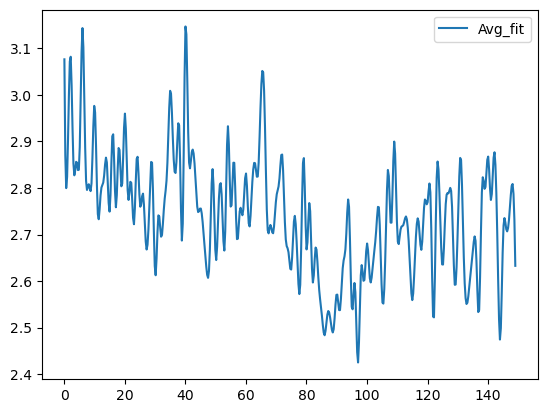

In [113]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

x, y = df_avgFit[0].values, df_avgFit[1].values 
spliner_xy = make_interp_spline(x, y)
x_sp = np.linspace(x.min(), x.max(), 500)
y_sp = spliner_xy(x_sp)
plt.plot(x_sp, y_sp, label="Avg_fit")
plt.legend()
plt.show()

In [72]:
top_top = np.argmax(p_fit)
top_pop = p[top_top]
top_g = nx.to_networkx_graph(top_pop)
# pos = nx.spring_layout(top_g, seed=123)  # Seed for reproducible layout
# nx.draw(top_g, pos=pos)

In [97]:
edges = top_g.edges()
caps = []
for i in edges:
    caps.append(gp.item()[i])

In [98]:
caps

[270,
 230,
 295,
 61,
 192,
 249,
 255,
 118,
 114,
 212,
 253,
 288,
 121,
 269,
 87,
 100,
 170,
 182,
 233,
 156,
 258,
 100,
 134,
 103,
 75,
 201,
 217,
 217,
 187,
 222,
 100,
 120,
 273,
 78,
 91,
 102,
 124,
 146,
 250,
 282,
 245,
 237,
 175,
 283,
 229,
 76,
 123,
 151,
 74,
 207,
 299,
 153,
 230,
 165,
 120,
 157,
 168,
 182,
 201,
 107]

In [102]:
pop_flow[top_top]

array([122.37701066,  27.42191948,  99.60345502, 146.833145  ,
        59.37098693,  29.83303823, 140.69150059, 170.771006  ,
       173.20540915,  91.11483568,  18.3248767 , 211.22298901,
        17.53599672, 108.10356999, 197.10000379, 132.82194894,
        69.86490565, 106.90143637, 186.00364893,  55.14401888,
        17.38149985, 177.12703381,  52.6347477 ,  10.25088297,
       182.85524353,  58.22742305, 152.20500583, 125.97263713,
        49.26520688,  51.75088087,  50.99241199,  17.531525  ,
       191.71800657,  46.49887656, 220.32136133,  97.32159747,
       210.04018014, 140.42251077, 183.12141452, 105.373821  ,
       135.49206265,  81.59132453,  58.376849  ,  62.32942971,
        59.30867832,  48.99559793,  47.45132302,  59.41315182,
       181.03745016, 133.68360894, 216.69841217,  34.98582768,
       140.68982899,  89.3242393 ,  22.09045425, 134.41258465,
        62.20295833,   6.2310919 ,  89.00536663,  43.95593311])

In [112]:
pop_flow[top_top]/np.array(caps)

array([0.45324819, 0.11922574, 0.33763883, 2.40710074, 0.30922389,
       0.1198114 , 0.55173137, 1.44721192, 1.51934569, 0.42978696,
       0.07243034, 0.73341316, 0.14492559, 0.40187201, 2.26551728,
       1.32821949, 0.41097003, 0.58737053, 0.79829892, 0.3534873 ,
       0.06737015, 1.77127034, 0.39279662, 0.09952314, 2.43806991,
       0.28968867, 0.70140556, 0.58051907, 0.2634503 , 0.23311208,
       0.50992412, 0.14609604, 0.70226376, 0.59613944, 2.42111386,
       0.95413331, 1.69387242, 0.96179802, 0.73248566, 0.37366603,
       0.55302883, 0.34426719, 0.33358199, 0.22024533, 0.25898986,
       0.64467892, 0.38578311, 0.39346458, 2.44645203, 0.64581454,
       0.72474385, 0.22866554, 0.61169491, 0.54135903, 0.18408712,
       0.85613111, 0.3702557 , 0.03423677, 0.44281277, 0.41080311])

In [ ]:
data = {"Links": list(edges), "Capacity (Kbps)": caps, "Flow (Kbps)": list(pop_flow[top_top]), "GA Utilization": pop_flow[top_top]/np.array(caps)}

In [ ]:
G = nx.to_networkx_graph(p[12])
pos = nx.spring_layout(G, seed=11)  # Seed for reproducible layout
nx.draw(G, pos=pos)
# plt.show()

### Skenario 2 ATM Problem

In [ ]:
# %load_ext autotime
atm_cap = np.array([
    150, 150, 225,
    225, 225, 150,
    150, 150, 150,
    150, 150, 150,
    150, 150, 150
])

experiment_sken2 = {}

for size in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    pop, fit, avg_fit_generations = innerga(size=size, generasi=1000, capacity=atm_cap)
    experiment_sken2[size] = {
        "population": pop,
        "fitness": fit,
        "avg_fit_generations": avg_fit_generations
    }

In [ ]:
import pickle

with open('./datastore/experiment_data/skenario2.pkl', 'wb') as fp:
    pickle.dump(experiment_sken2, fp)
    print("dictionary saved succesfully to file")

In [ ]:
import matplotlib.pyplot as plt

pop10 = experiment_sken2[50]
pop10["population"]

In [ ]:
pop10["avg_fit_generations"]